# Descripción del problema

Crear un algoritmo de clasificación que ayude a predecir si un cliente del Banco Portugués suscribirá o no un depósito a plazo.

### Primero se instalan e importan las librerías
ejecutar en consola: `pip install -r requirements.txt`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### Step 1: cargar archivo

In [3]:
# se carga archivo de la web
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv', delimiter=';')

In [4]:
df_raw.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29994,65,retired,married,basic.4y,no,unknown,unknown,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,yes
8435,37,admin.,divorced,basic.9y,no,no,no,telephone,jun,tue,...,7,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,yes
15079,33,management,single,basic.9y,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no


In [5]:
# se guarda en la carpeta data/raw
df_raw.to_csv('../data/raw/dataset_bank.csv')

### Diccionario de variables

* Age (numerical)
* Job: Type of Job (categorical)
* Marital: marital status (categorical)
* Education: (categorical)
* Default: has credit in default? (categorical)
* Housing: has housing loan? (categorical)
* Loan: has personal loan? (categorical)
* contact: contact communication type (categorcial)
* month: last contact month of year (categorical)
* day_of_week: last contact day of the week (categorical)
* duration: last contact duration, in seconds (numerical)
**Important note:** this output highly affects the output target (if duration = 0, then y = 'no'). Yet, the duration is not known before a call is performed. Also, after the end of the call, y is obviously known. Consider if you should include it or not for a realistic predictive model.
* campaign: number of contacts performed during this campaign and for this client (numerical)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numerical)
* poutcome: outcome of the previous marketing campaign (categorical)
**Important note:** this attribute has three categories: 'failure', 'success' and 'non-existent'. 86% of the data falls into 'non-existent' category.
* emp.var.rate: employment variation rate - quarterly indicator (numeric)
* cons.price.idx: consumer price index- monthly indicator (numeric)
* cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* euribor3m: euribor 3 month rate: - daily indicator(numeric)
* nr.employed: number of employees - quarterly indicator (numeric)
* **Target variable:** y, has the client subscribed a term deposit?

### Steps 2 y 3: Breve EDA del dataset

In [6]:
# se carga desde la carpeta
df_bank = pd.read_csv('../data/raw/dataset_bank.csv', index_col = 0)

In [7]:
# chequeo dimensiones
df_bank.shape

(41188, 21)

El data frame contiene 41188 registros (filas) y 21 variables (columnas)

In [8]:
# miro 5 observaciones al azar
df_bank.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
39292,31,admin.,single,university.degree,no,yes,no,telephone,mar,tue,...,1,3,2,success,-1.8,93.369,-34.8,0.646,5008.7,yes
3310,45,housemaid,divorced,university.degree,no,yes,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
30773,43,blue-collar,married,basic.9y,unknown,yes,no,cellular,may,tue,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,no
35211,25,blue-collar,married,basic.4y,no,no,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
11927,31,services,single,professional.course,no,yes,no,telephone,jun,fri,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no


In [9]:
# info básica
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Apreciaciones:**

* no hay valores nulos en ninguna de las variables
* hay que convertir las variables de tipo object a categorical

#### Visualización de las categorías de cada variable categórica y cómo se distribuyen, recodificación para sustituir categorías "unknown"

Tipo de trabajo

In [10]:
# Tipo de trabajo
print(df_bank['job'].value_counts())
print(f'Cantidad de categorías: {df_bank["job"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['job'] == 'unknown'
df_bank.loc[mask, 'job'] = 'admin.'
print(df_bank['job'].value_counts())

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
Cantidad de categorías: 12
admin.           10752
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64


Estado civil

In [11]:
# Estado civil
print(df_bank['marital'].value_counts())
print(f'Cantidad de categorías: {df_bank["marital"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['marital'] == 'unknown'
df_bank.loc[mask, 'marital'] = 'married'
print(df_bank['marital'].value_counts())

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
Cantidad de categorías: 4
married     25008
single      11568
divorced     4612
Name: marital, dtype: int64


Nivel educativo

In [12]:
# Nivel educativo
print(df_bank['education'].value_counts())
print(f'Cantidad de categorías: {df_bank["education"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['education'] == 'unknown'
df_bank.loc[mask, 'education'] = 'university.degree'
print(df_bank['education'].value_counts())

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
Cantidad de categorías: 8
university.degree      13899
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64


Créditos en default?

In [13]:
# Tiene créditos en default?
print(df_bank['default'].value_counts())
print(f'Cantidad de categorías: {df_bank["default"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['default'] == 'unknown'
df_bank.loc[mask, 'default'] = 'no'
print(df_bank['default'].value_counts())

no         32588
unknown     8597
yes            3
Name: default, dtype: int64
Cantidad de categorías: 3
no     41185
yes        3
Name: default, dtype: int64


Préstamo de vivienda?

In [14]:
# Tiene préstamo de vivienda?
print(df_bank['housing'].value_counts())
print(f'Cantidad de categorías: {df_bank["housing"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['housing'] == 'unknown'
df_bank.loc[mask, 'housing'] = 'yes'
print(df_bank['housing'].value_counts())


yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
Cantidad de categorías: 3
yes    22566
no     18622
Name: housing, dtype: int64


Algún préstamo?

In [15]:
# Tiene algún préstamo?
print(df_bank['loan'].value_counts())
print(f'Cantidad de categorías: {df_bank["loan"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['loan'] == 'unknown'
df_bank.loc[mask, 'loan'] = 'no'
print(df_bank['loan'].value_counts())


no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
Cantidad de categorías: 3
no     34940
yes     6248
Name: loan, dtype: int64


Tipo de contacto

In [16]:
# Tipo de contacto
print(df_bank['contact'].value_counts())
print(f'Cantidad de categorías: {df_bank["contact"].nunique()}')

# esta variable no tiene categoría "unknown" 

cellular     26144
telephone    15044
Name: contact, dtype: int64
Cantidad de categorías: 2


Mes del último contacto

In [17]:
# Mes del último contacto
print(df_bank['month'].value_counts())
print(f'Cantidad de categorías: {df_bank["month"].nunique()}')

# esta variable no tiene categoría "unknown" 

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64
Cantidad de categorías: 10


Día de la semana del último contacto

In [18]:
# Día de la semana del último contacto
print(df_bank['day_of_week'].value_counts())
print(f'Cantidad de categorías: {df_bank["day_of_week"].nunique()}')

# esta variable no tiene categoría "unknown" 

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64
Cantidad de categorías: 5


Resultado de la campaña anterior

In [19]:
# Resultado de la campaña anterior
print(df_bank['poutcome'].value_counts())
print(f'Cantidad de categorías: {df_bank["poutcome"].nunique()}')

# esta variable no tiene categoría "unknown" 

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64
Cantidad de categorías: 3


Se convierten a categorical

In [20]:
# convierto a categóricas
cols = df_bank.select_dtypes(include = ['object']).columns
for i in cols:
    df_bank[i] = pd.Categorical(df_bank[i])
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

Ahora se analiza la variable target

In [21]:
# variable respuesta, dependiente o target: cliente suscribió un plazo fijo?
print(df_bank['y'].value_counts())
print(f'Cantidad de categorías: {df_bank["y"].nunique()}')

no     36548
yes     4640
Name: y, dtype: int64
Cantidad de categorías: 2


In [21]:
print(f'yes = {round(100*sum(df_bank["y"] == "yes")/len(df_bank))}%')
print(f'no = {round(100*sum(df_bank["y"] == "no")/len(df_bank))}%')

yes = 11%
no = 89%


La distribución de la variable target está desbalanceada!!

Resumen de las variables numéricas:

In [22]:
df_bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Cosas que llaman la atención:
* hay contactos con duración = 0 (no hubo contacto anterior, además según indica la tarea esos tienen y = 'No'), y el máximo es 4918 seg (81 hs!!)
* en pdays hay que tener cuidado con 999 (si es la primera campaña)



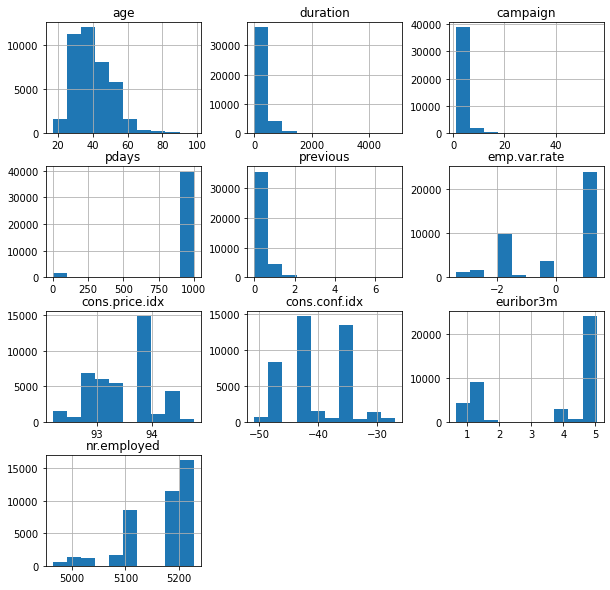

In [23]:
# histogramas
df_bank.hist(figsize=(10, 10))
plt.show()

In [31]:
np.dtype(df_bank)

TypeError: Cannot interpret '       age          job  marital            education default housing loan  \
0       56    housemaid  married             basic.4y      no      no   no   
1       57     services  married          high.school      no      no   no   
2       37     services  married          high.school      no     yes   no   
3       40       admin.  married             basic.6y      no      no   no   
4       56     services  married          high.school      no      no  yes   
...    ...          ...      ...                  ...     ...     ...  ...   
41183   73      retired  married  professional.course      no     yes   no   
41184   46  blue-collar  married  professional.course      no      no   no   
41185   56      retired  married    university.degree      no     yes   no   
41186   44   technician  married  professional.course      no      no   no   
41187   74      retired  married  professional.course      no     yes   no   

         contact month day_of_week  ...  campaign  pdays  previous  \
0      telephone   may         mon  ...         1    999         0   
1      telephone   may         mon  ...         1    999         0   
2      telephone   may         mon  ...         1    999         0   
3      telephone   may         mon  ...         1    999         0   
4      telephone   may         mon  ...         1    999         0   
...          ...   ...         ...  ...       ...    ...       ...   
41183   cellular   nov         fri  ...         1    999         0   
41184   cellular   nov         fri  ...         1    999         0   
41185   cellular   nov         fri  ...         2    999         0   
41186   cellular   nov         fri  ...         1    999         0   
41187   cellular   nov         fri  ...         3    999         1   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent          1.1          93.994          -36.4      4.857   
1      nonexistent          1.1          93.994          -36.4      4.857   
2      nonexistent          1.1          93.994          -36.4      4.857   
3      nonexistent          1.1          93.994          -36.4      4.857   
4      nonexistent          1.1          93.994          -36.4      4.857   
...            ...          ...             ...            ...        ...   
41183  nonexistent         -1.1          94.767          -50.8      1.028   
41184  nonexistent         -1.1          94.767          -50.8      1.028   
41185  nonexistent         -1.1          94.767          -50.8      1.028   
41186  nonexistent         -1.1          94.767          -50.8      1.028   
41187      failure         -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]' as a data type

ValueError: boxplot method requires numerical columns, nothing to plot.

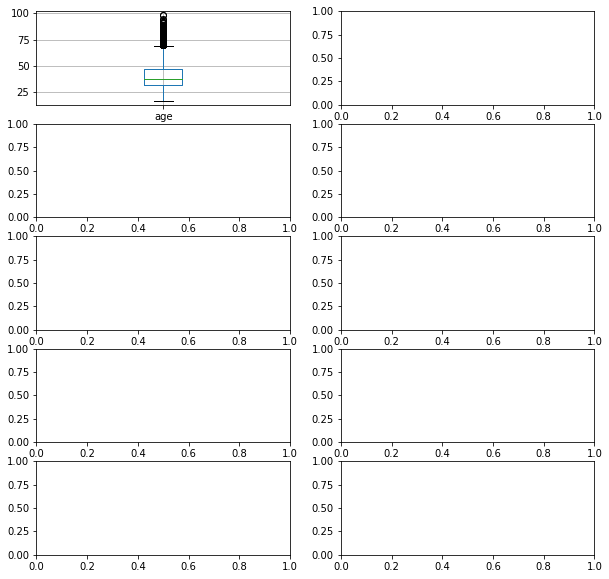

In [25]:
# boxplot
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
axs = ax.flatten()
for i in range(9):
    df_bank.iloc[:, i].to_frame().boxplot(ax=axs[i])
plt.suptitle("BoxPlot")
plt.show()

In [9]:
X = df_raw.drop(columns = ['y'])

In [10]:
y = df_raw['y']

In [ ]:
X.select_dtypes(include = ['int', 'float']).columns